### 1. 第一个量化策略

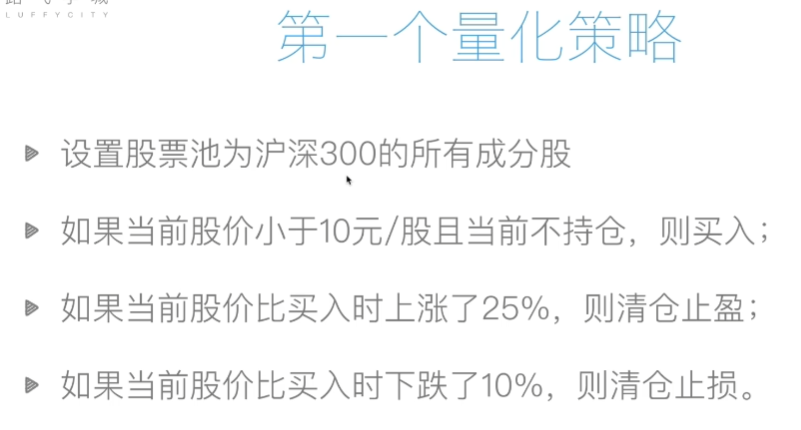
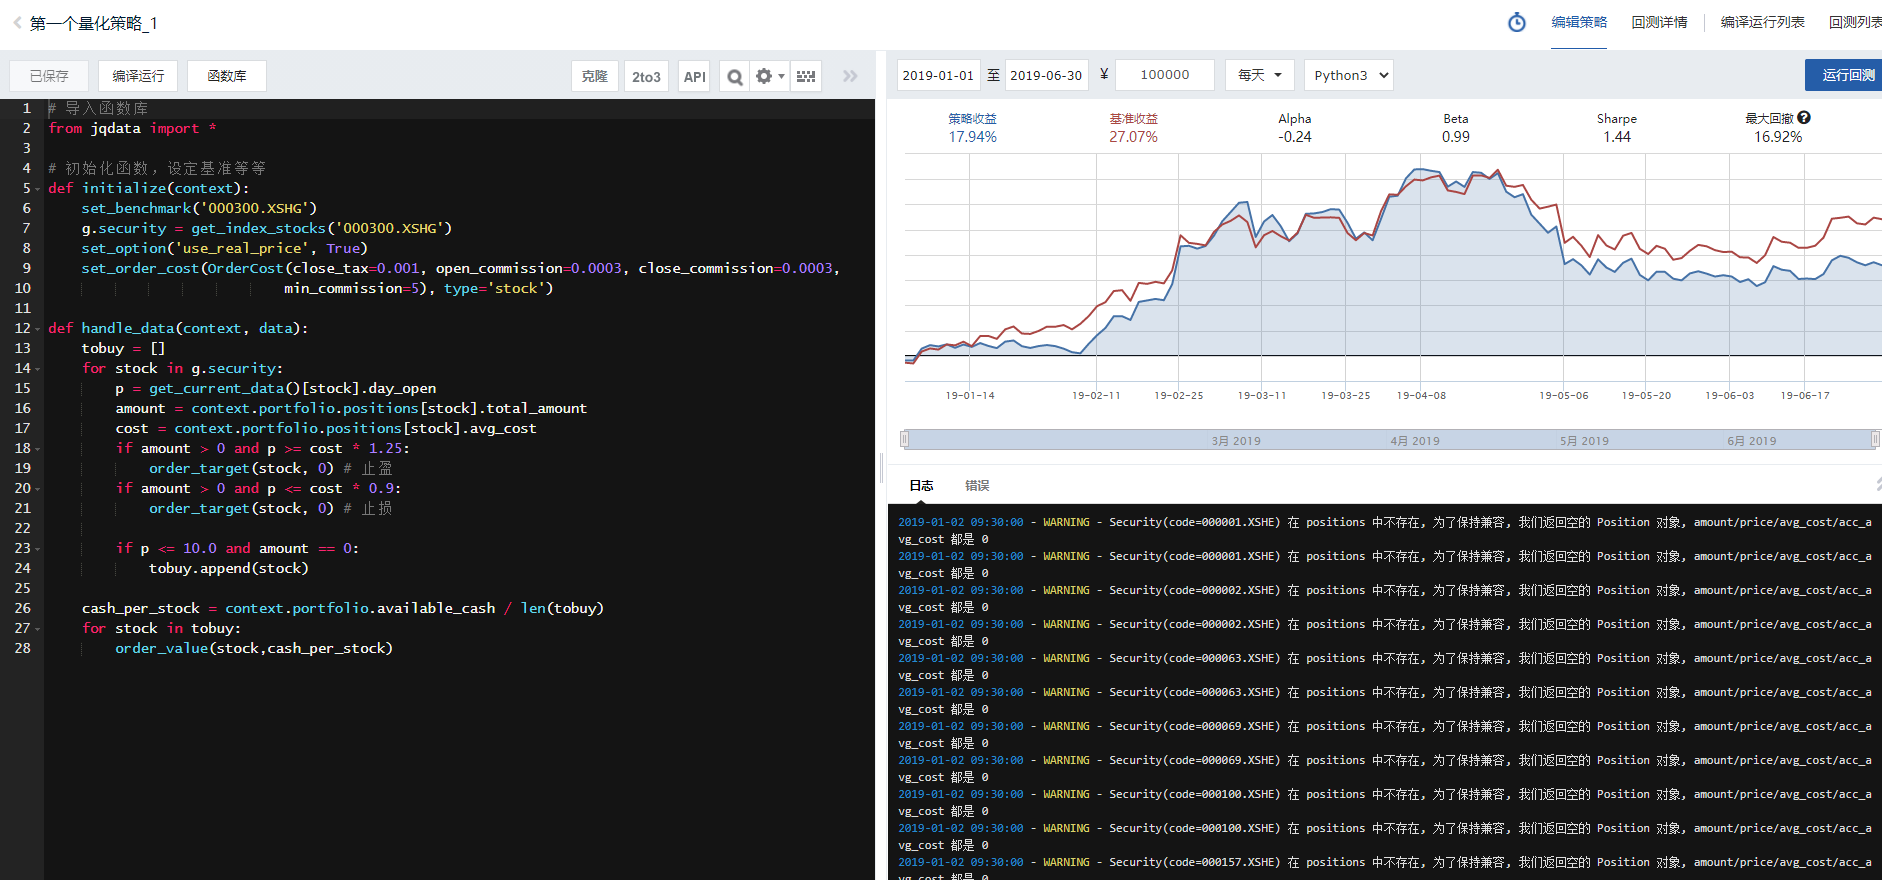

In [ ]:
# 导入函数库
from jqdata import *

# 初始化函数，设定基准等等
def initialize(context):
    set_benchmark('000300.XSHG')
    g.security = get_index_stocks('000300.XSHG')
    set_option('use_real_price', True)
    set_order_cost(OrderCost(close_tax=0.001, open_commission=0.0003, close_commission=0.0003,
                            min_commission=5), type='stock')

def handle_data(context, data):
    tobuy = []
    for stock in g.security:
        p = get_current_data()[stock].day_open
        amount = context.portfolio.positions[stock].total_amount
        cost = context.portfolio.positions[stock].avg_cost
        if amount > 0 and p >= cost * 1.25:
            order_target(stock, 0) # 止盈
        if amount > 0 and p <= cost * 0.9:
            order_target(stock, 0) # 止损
        
        if p <= 10.0 and amount == 0:
            tobuy.append(stock)
    
    cash_per_stock = context.portfolio.available_cash / len(tobuy)
    for stock in tobuy:
        order_value(stock,cash_per_stock)

### 2. 双均线策略 （`核心在于择时`）
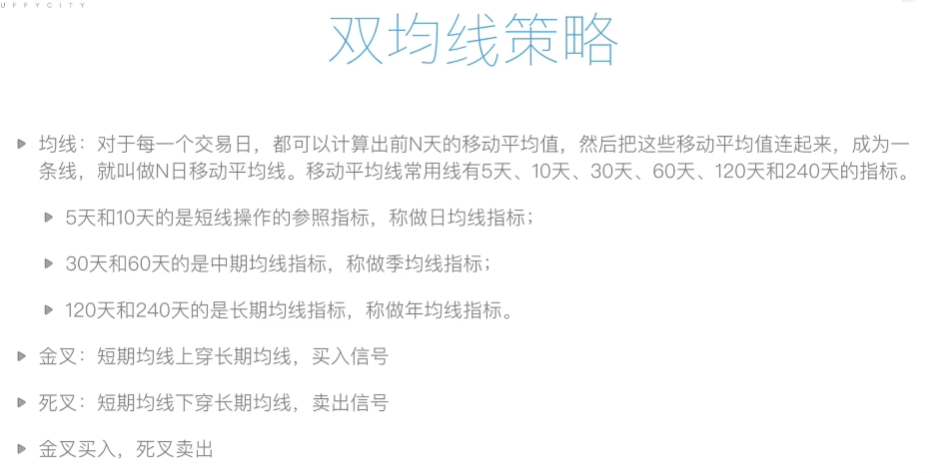
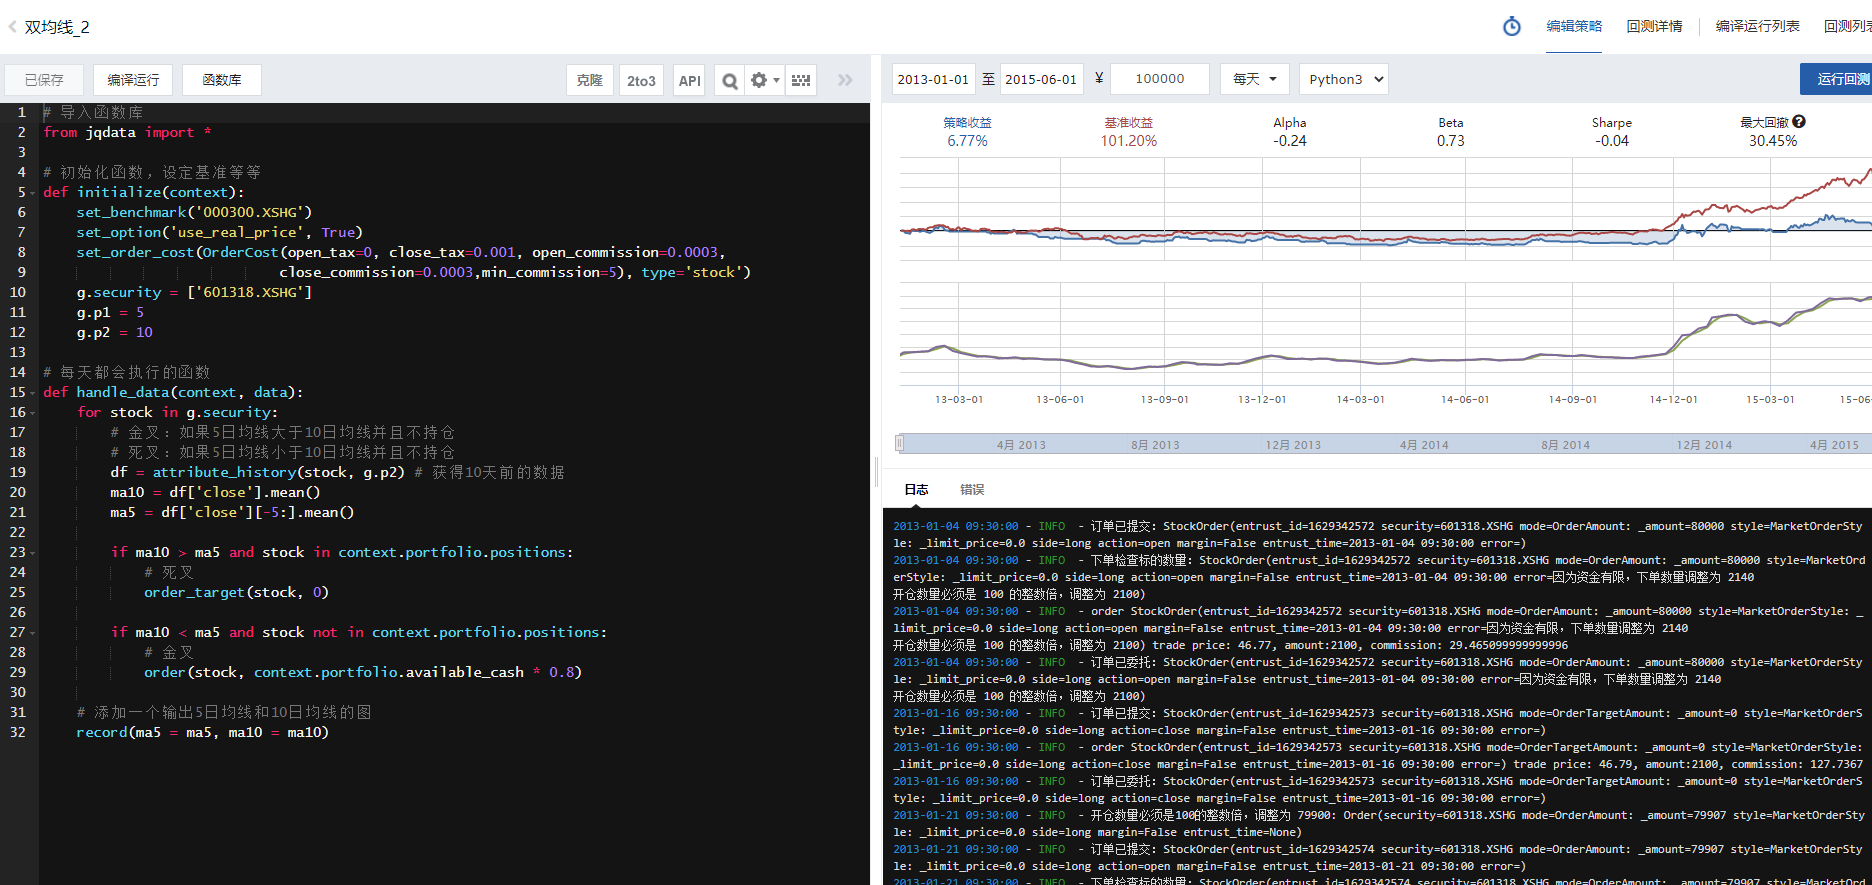

In [ ]:
# 导入函数库
from jqdata import *

# 初始化函数，设定基准等等
def initialize(context):
    set_benchmark('000300.XSHG')
    set_option('use_real_price', True)
    set_order_cost(OrderCost(open_tax=0, close_tax=0.001, open_commission=0.0003,
                            close_commission=0.0003,min_commission=5), type='stock')
    g.security = ['601318.XSHG']
    g.p1 = 5
    g.p2 = 10
    
# 每天都会执行的函数
def handle_data(context, data):
    for stock in g.security:
        # 金叉：如果5日均线大于10日均线并且不持仓
        # 死叉：如果5日均线小于10日均线并且不持仓
        df = attribute_history(stock, g.p2) # 获得10天前的数据
        ma10 = df['close'].mean()
        ma5 = df['close'][-5:].mean()
        
        if ma10 > ma5 and stock in context.portfolio.positions:
            # 死叉
            order_target(stock, 0)
        
        if ma10 < ma5 and stock not in context.portfolio.positions:
            # 金叉
            order(stock, context.portfolio.available_cash * 0.8)
        
    # 添加一个输出5日均线和10日均线的图
    record(ma5 = ma5, ma10 = ma10)

### 3. 因子选股策略 （核心在于`选股`）
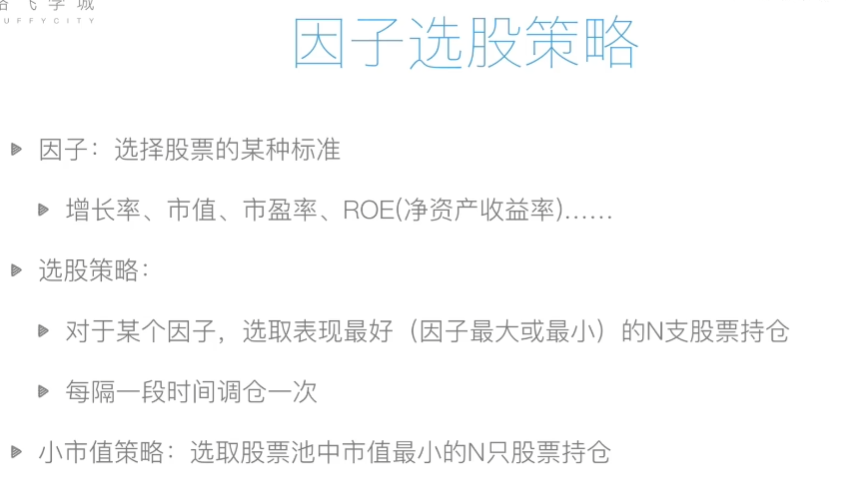
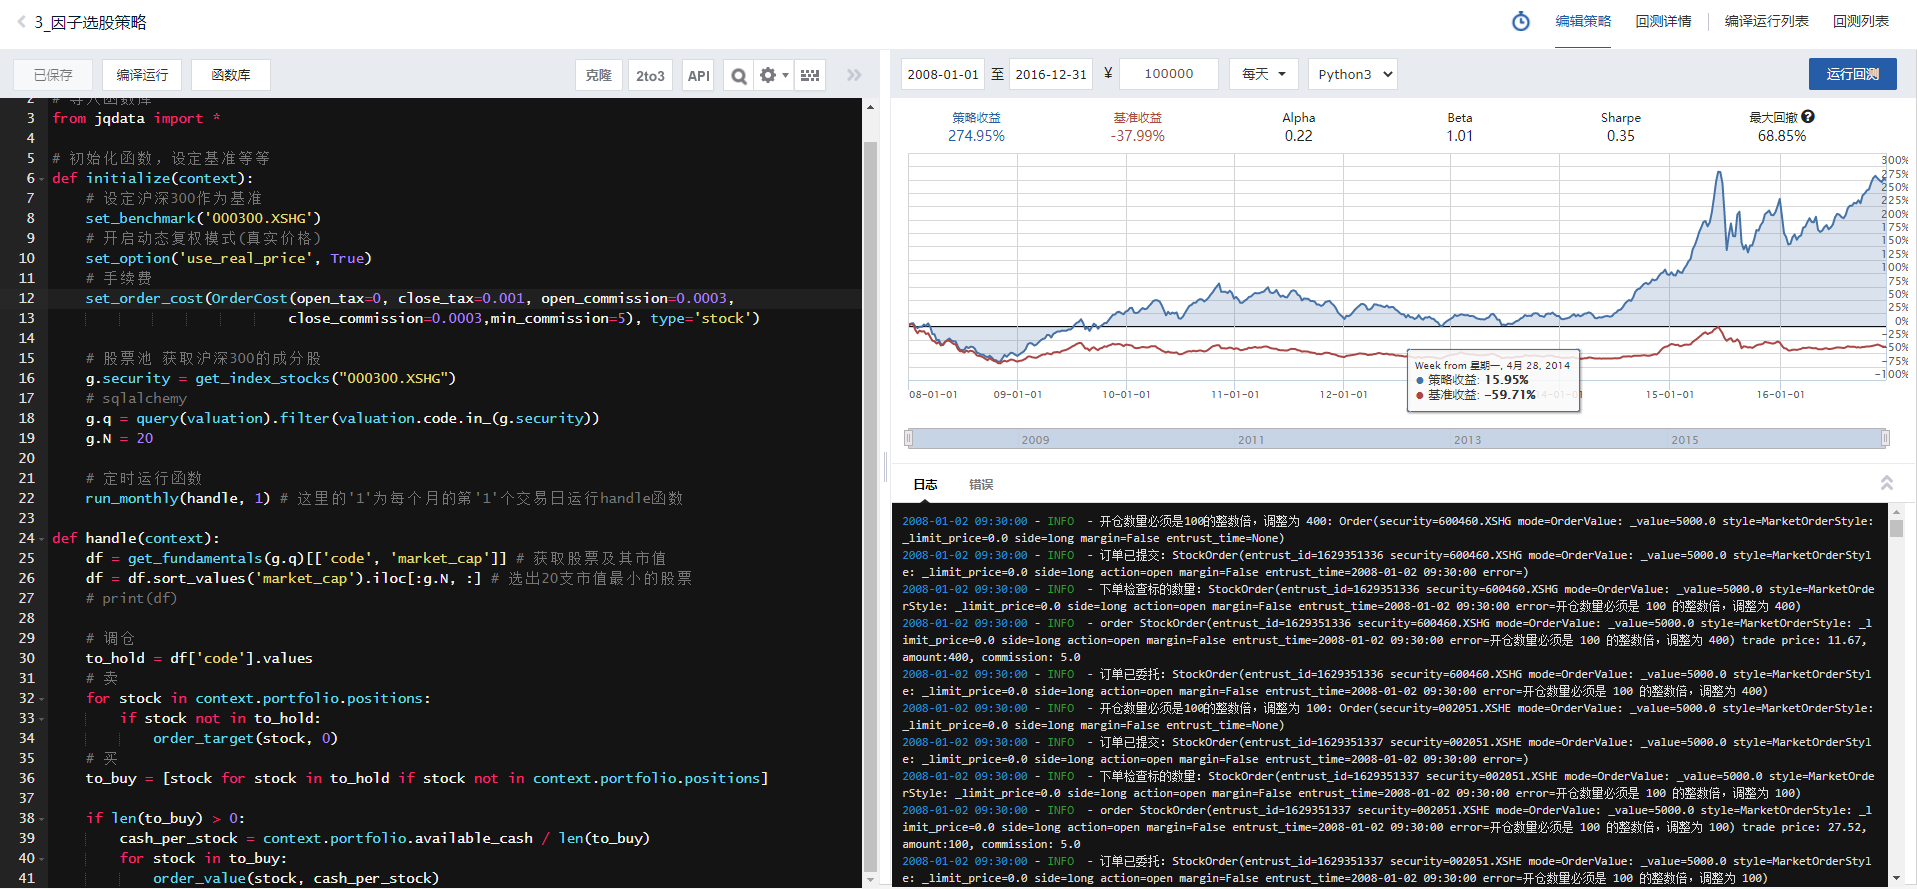

In [ ]:
# 小市值策略
# 导入函数库
from jqdata import *

# 初始化函数，设定基准等等
def initialize(context):
    # 设定沪深300作为基准
    set_benchmark('000300.XSHG')
    # 开启动态复权模式(真实价格)
    set_option('use_real_price', True)
    # 手续费
    set_order_cost(OrderCost(open_tax=0, close_tax=0.001, open_commission=0.0003,
                            close_commission=0.0003,min_commission=5), type='stock')
    
    # 股票池 获取沪深300的成分股
    g.security = get_index_stocks("000300.XSHG")
    # sqlalchemy
    g.q = query(valuation).filter(valuation.code.in_(g.security))
    g.N = 20
    
    # 定时运行函数
    run_monthly(handle, 1) # 这里的'1'为每个月的第'1'个交易日运行handle函数
    
def handle(context):
    df = get_fundamentals(g.q)[['code', 'market_cap']] # 获取股票及其市值
    df = df.sort_values('market_cap').iloc[:g.N, :] # 选出20支市值最小的股票
    # print(df)
    
    # 调仓
    to_hold = df['code'].values
    # 卖
    for stock in context.portfolio.positions:
        if stock not in to_hold:
            order_target(stock, 0)
    # 买
    to_buy = [stock for stock in to_hold if stock not in context.portfolio.positions]
    
    if len(to_buy) > 0:
        cash_per_stock = context.portfolio.available_cash / len(to_buy)
        for stock in to_buy:
            order_value(stock, cash_per_stock)

### 4. 多因子选股策略
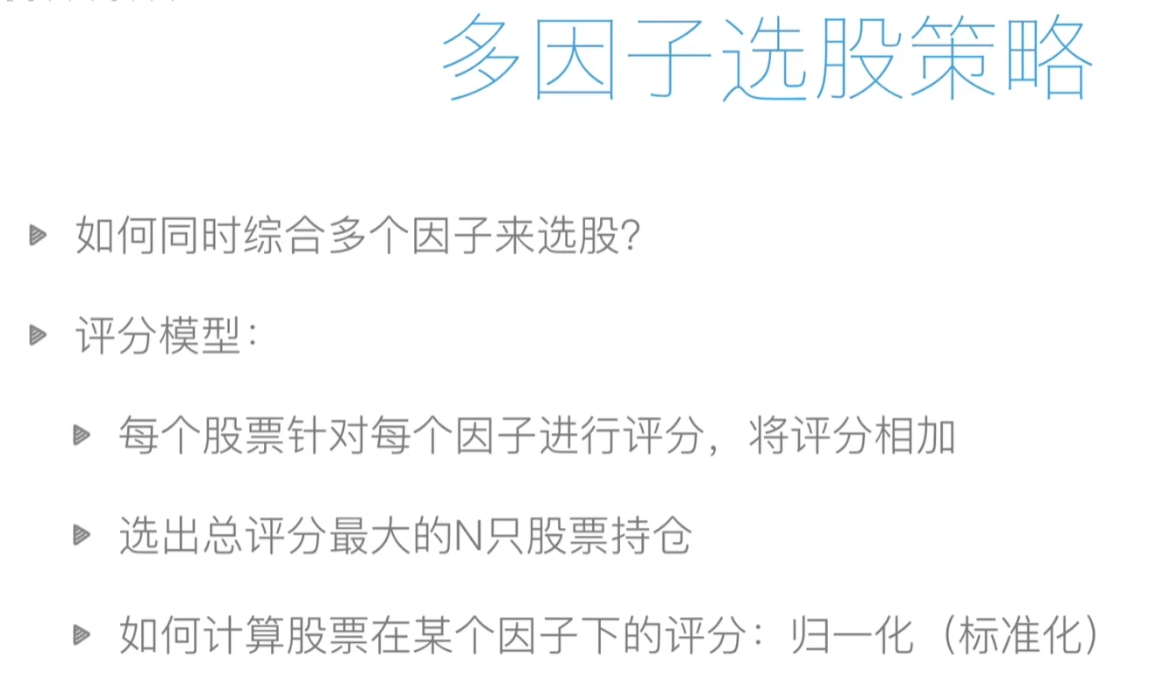
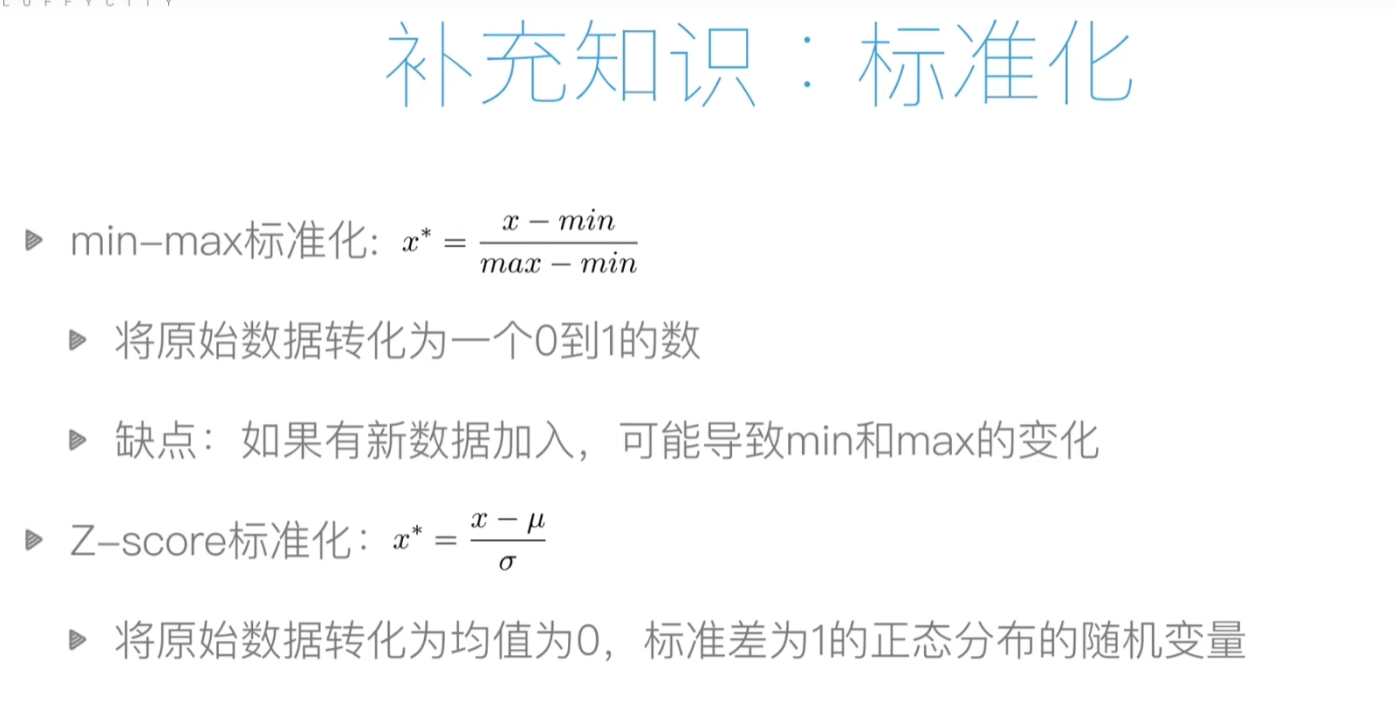
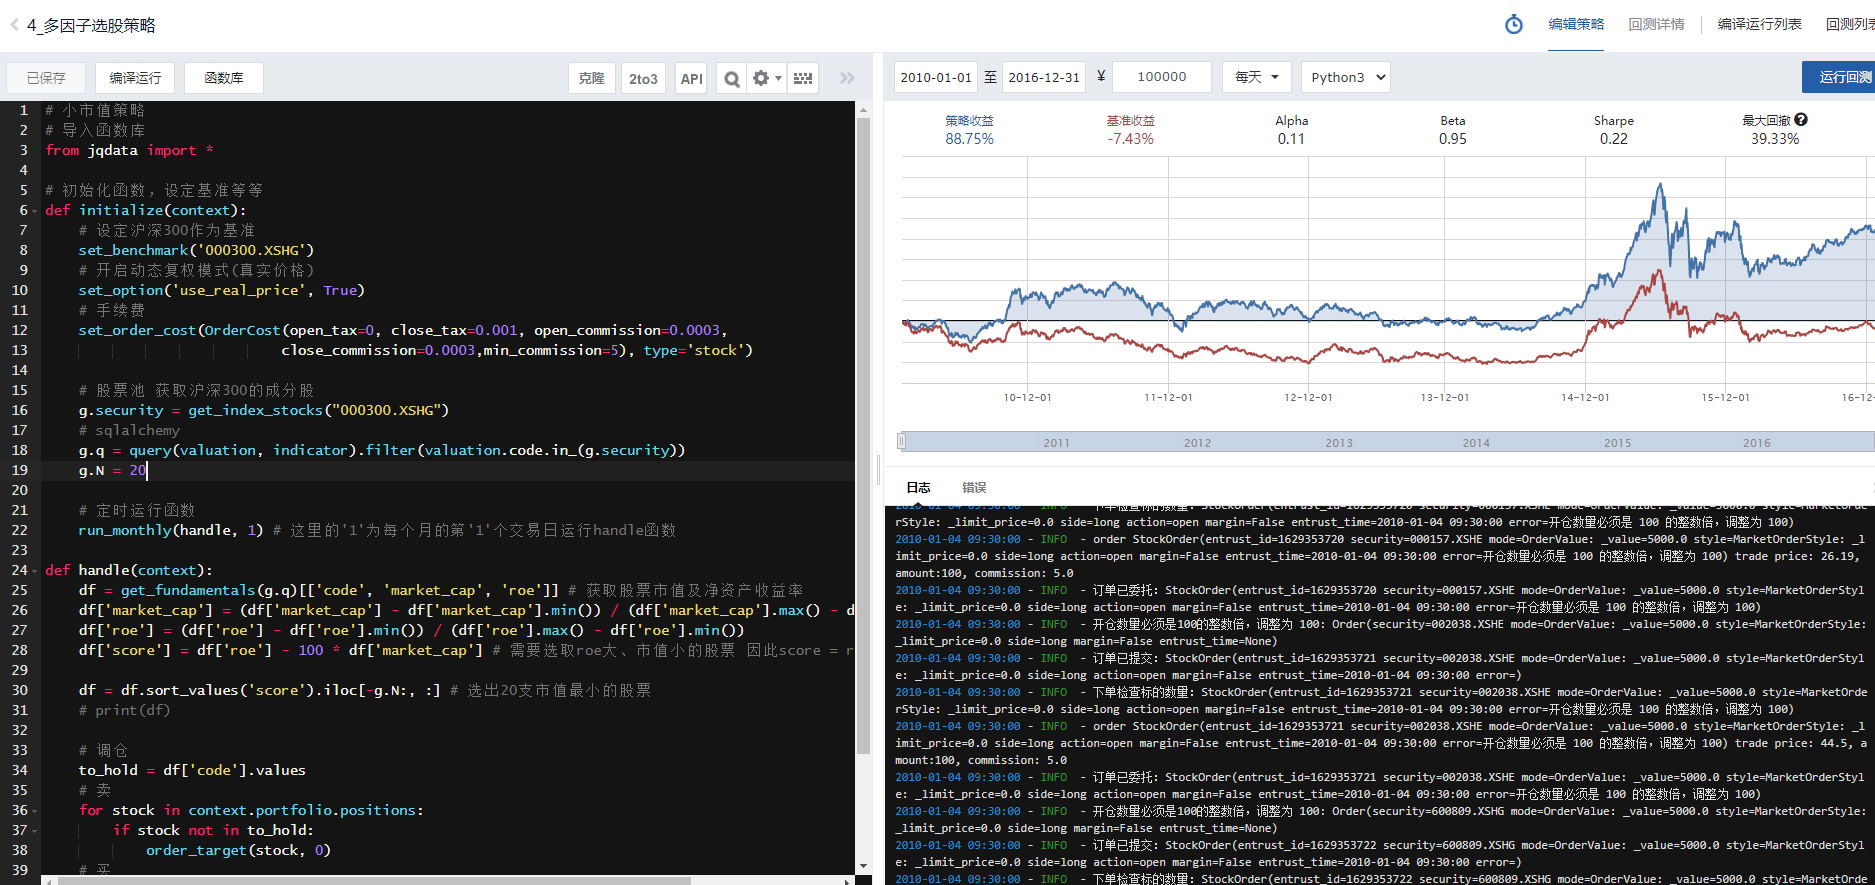

In [ ]:
# 小市值策略
# 导入函数库
from jqdata import *

# 初始化函数，设定基准等等
def initialize(context):
    # 设定沪深300作为基准
    set_benchmark('000300.XSHG')
    # 开启动态复权模式(真实价格)
    set_option('use_real_price', True)
    # 手续费
    set_order_cost(OrderCost(open_tax=0, close_tax=0.001, open_commission=0.0003,
                            close_commission=0.0003,min_commission=5), type='stock')
    
    # 股票池 获取沪深300的成分股
    g.security = get_index_stocks("000300.XSHG")
    # sqlalchemy
    g.q = query(valuation, indicator).filter(valuation.code.in_(g.security))
    g.N = 20
    
    # 定时运行函数
    run_monthly(handle, 1) # 这里的'1'为每个月的第'1'个交易日运行handle函数
    
def handle(context):
    df = get_fundamentals(g.q)[['code', 'market_cap', 'roe']] # 获取股票市值及净资产收益率
    df['market_cap'] = (df['market_cap'] - df['market_cap'].min()) / (df['market_cap'].max() - df['market_cap'].min())
    df['roe'] = (df['roe'] - df['roe'].min()) / (df['roe'].max() - df['roe'].min())
    df['score'] = df['roe'] - 100 * df['market_cap'] # 需要选取roe大、市值小的股票 因此score = roe - 市值
    
    df = df.sort_values('score').iloc[-g.N:, :] # 选出20支市值最小的股票
    # print(df)
    
    # 调仓
    to_hold = df['code'].values
    # 卖
    for stock in context.portfolio.positions:
        if stock not in to_hold:
            order_target(stock, 0)
    # 买
    to_buy = [stock for stock in to_hold if stock not in context.portfolio.positions]
    
    if len(to_buy) > 0:
        cash_per_stock = context.portfolio.available_cash / len(to_buy)
        for stock in to_buy:
            order_value(stock, cash_per_stock)